In [4]:
%pip install wfdb

In [5]:
import wfdb
import pywt
import numpy
import scipy
import matplotlib
print("All libraries imported successfully!")


All libraries imported successfully!


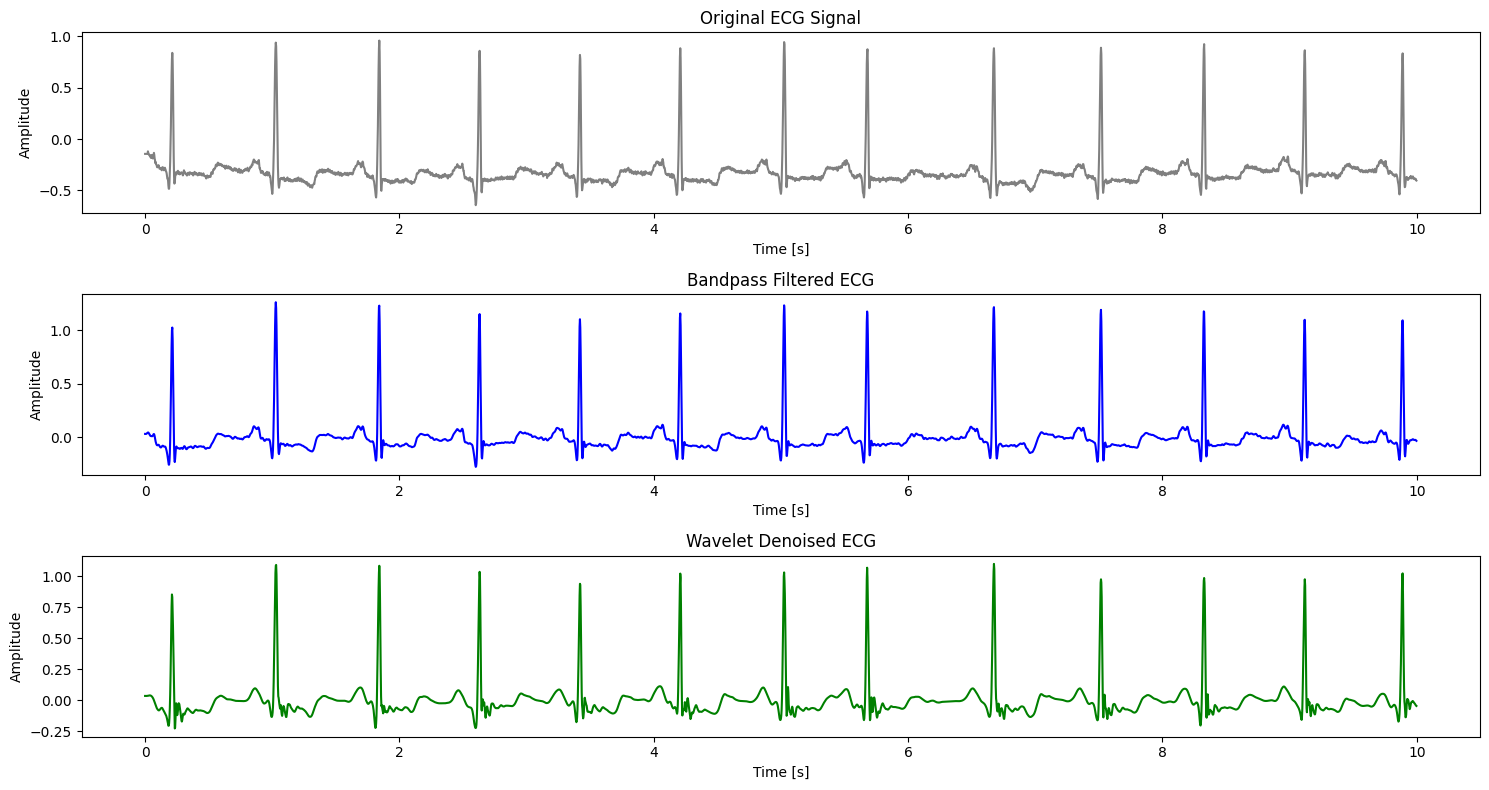

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pywt
from scipy.signal import butter, filtfilt

# Step 1: Load ECG signal from PhysioNet (MIT-BIH database)
def load_ecg_sample(record_name='100', duration=10, channel=0):
    # Specify the database and record name
    record = wfdb.rdrecord(record_name, sampfrom=0, sampto=360*duration, channels=[channel], pn_dir='mitdb')
    signal = record.p_signal.flatten()
    fs = record.fs
    return signal, fs

# Step 2: Bandpass Butterworth Filter
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Step 3: Wavelet Denoising
def wavelet_denoise(signal, wavelet='db6', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Estimate the noise standard deviation using the median absolute deviation of the finest level detail coefficients
    sigma = np.median(np.abs(coeffs[-level] - np.median(coeffs[-level]))) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_denoised = [pywt.threshold(c, value=uthresh, mode='soft') if i != 0 else c
                       for i, c in enumerate(coeffs)]
    return pywt.waverec(coeffs_denoised, wavelet)

# Step 4: Plotting
def plot_signals(original, filtered, denoised, fs):
    t = np.arange(len(original)) / fs
    plt.figure(figsize=(15, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, original, label='Original ECG', color='gray')
    plt.title('Original ECG Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(t, filtered, label='Bandpass Filtered', color='blue')
    plt.title('Bandpass Filtered ECG')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(t[:len(denoised)], denoised, label='Wavelet Denoised', color='green')
    plt.title('Wavelet Denoised ECG')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# Main pipeline
ecg_signal, fs = load_ecg_sample('100')  # MIT-BIH record 100
filtered_signal = bandpass_filter(ecg_signal, 0.5, 45, fs)
denoised_signal = wavelet_denoise(filtered_signal)

plot_signals(ecg_signal, filtered_signal, denoised_signal, fs)